In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_data(in_file, data_type = 'ill'):
    #tmp_csv = f'{in_dir}/tmp_{data_type}_{ch}.csv'    

    data = pd.read_csv(in_file, sep = ',', on_bad_lines='skip') 
    data['pos'] = range(1, len(data) + 1)
    
    if data_type == 'ill':
        data['original_BAF'] = data['BAF_ILL']
        data['BAF_ILL'] = data['BAF_ILL'].apply(lambda x: 1.01 - x if x > 0.5 else x)
        data['BAF_ILL'] = data['BAF_ILL'].apply(lambda x: 0.01 if x == 0 else x)
        
        data = data[data['BAF_ILL']>0]
        data_input = {'baf':torch.tensor(np.array(data.BAF_ILL).reshape(-1, 1)),
                      'dr':torch.tensor(np.array(data.DR_ILL).reshape(-1, 1)),
                      'dp_snp':torch.tensor(np.array(data.DP_ILL).reshape(-1, 1)),
                      'orginal_baf':torch.tensor(np.array(data.original_BAF).reshape(-1, 1))}
    
    elif data_type == 'np':
        data['original_BAF'] = data['BAF_NP']
        data['BAF_NP'] = data['BAF_NP'].apply(lambda x: 1.01 - x if x > 0.5 else x)
        data['BAF_NP'] = data['BAF_NP'].apply(lambda x: 0.01 if x == 0 else x)
        
        data = data[data['BAF_NP']>0]
        data_input = {'baf':torch.tensor(np.array(data.BAF_NP).reshape(-1, 1)),
                      'dr':torch.tensor(np.array(data.DR_NP).reshape(-1, 1)),
                      'dp_snp':torch.tensor(np.array(data.DP_NP).reshape(-1, 1)),
                      'orginal_baf':torch.tensor(np.array(data.original_BAF).reshape(-1, 1))}
    
    return data_input


In [10]:
data = pd.read_csv("/Users/lucreziavaleriani/Desktop/PDO61_chr19.csv", sep = ',', on_bad_lines='skip') 

In [11]:
data['original_BAF_ILL'] = data['BAF_ILL']
data['BAF_ILL'] = data['BAF_ILL'].apply(lambda x: 1.01 - x if x > 0.5 else x)
data['BAF_ILL'] = data['BAF_ILL'].apply(lambda x: 0.01 if x == 0 else x)
data = data[data['BAF_ILL']>0]


data['original_BAF_NP'] = data['BAF_NP']
#data['BAF_NP'] = data['BAF_NP'].apply(lambda x: 1.01 - x if x > 0.5 else x)
#data['BAF_NP'] = data['BAF_NP'].apply(lambda x: 0.01 if x == 0 else x)
data = data[data['BAF_NP']>0]

In [12]:
data_input = {'baf_np':torch.tensor(np.array(data.BAF_NP).reshape(-1, 1)),
              'dr_np':torch.tensor(np.array(data.DR_NP).reshape(-1, 1)),
              'dp_snp_np':torch.tensor(np.array(data.DP_NP).reshape(-1, 1)),
              'orginal_baf_np':torch.tensor(np.array(data.original_BAF_NP).reshape(-1, 1)),
              'baf_ill':torch.tensor(np.array(data.BAF_ILL).reshape(-1, 1)),
              'dr_ill':torch.tensor(np.array(data.DR_ILL).reshape(-1, 1)),
              'dp_snp_ill':torch.tensor(np.array(data.DP_ILL).reshape(-1, 1)),
              'orginal_baf_ill':torch.tensor(np.array(data.original_BAF_ILL).reshape(-1, 1))
            }

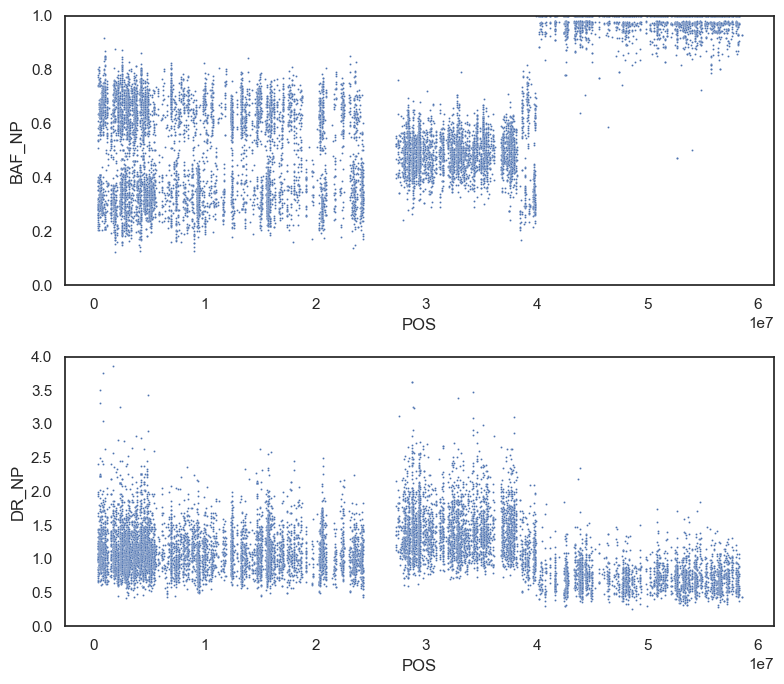

In [13]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(2, 1, figsize=(8, 7))

baf = sns.scatterplot(data=data, x="POS", y="BAF_NP", s=2, ax=axes[0]), #hue="CN")
dr = sns.scatterplot(data=data, x="POS", y="DR_NP", s=2, ax=axes[1])#, hue="CN", legend=False)

axes[0].set_ylim(0,1)
axes[1].set_ylim(0,4) 

fig.tight_layout()

In [14]:
import locate.locate as l
from locate.models import Clonal, JoinClonal
from locate.utils import plot_loss

In [15]:
locate = l.LOCATE(CUDA = False)
#data_name = set(['baf', 'dr', 'dp_snp', 'vaf', 'dp', 'baf_ill', 'dr_ill', 'dp_snp_ill'])


locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf_np"],
                         "dr":data_input["dr_np"], 
                         "dp_snp":data_input["dp_snp_np"], 
                        #  "baf_ill":data_input["baf_ill"],
                        #  "dr_ill":data_input["dr_ill"],
                        #  "dp_snp_ill":data_input["dp_snp_ill"],
                         "vaf": None, 
                         "dp": None})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": True,
                         "fix_ploidy" : True, 
                         "prior_purity": 0.9,
                         "prior_ploidy": 2,
                         "scaling_factors": [1,1,1],
                         "prior_bp": False,
                         'hidden_dim': 4
                         })

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [16]:
ll = locate.run(steps = 500, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/models/Clonal.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((1 - self._params["jumping_prob"]) * torch.eye(x.shape[0]) + self._params["jumping_prob"])
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -13049.513331428  :   0%|          | 0/500 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: T

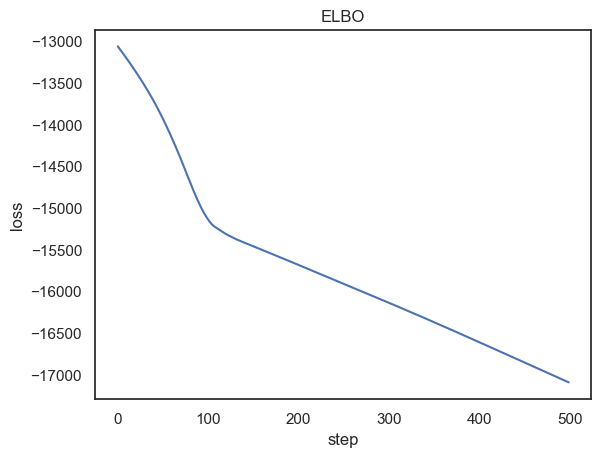

In [17]:
plot_loss(ll[0])

In [18]:
params = locate.learned_parameters_Clonal()

In [14]:
params['purity']

KeyError: 'purity'

In [19]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [20]:
res_tosave = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                           'CN_minor':params["CN_minor"]-0.05,
                            'baf':data.BAF_NP,
                            'dr':data.DR_NP,
                            'or_baf':data.original_BAF_NP,
                            'pos':[i for i in range(len(params["CN_minor"]))],
                            })
# res_tosave.to_csv('~/Desktop/PDO61_res.csv', header=True)

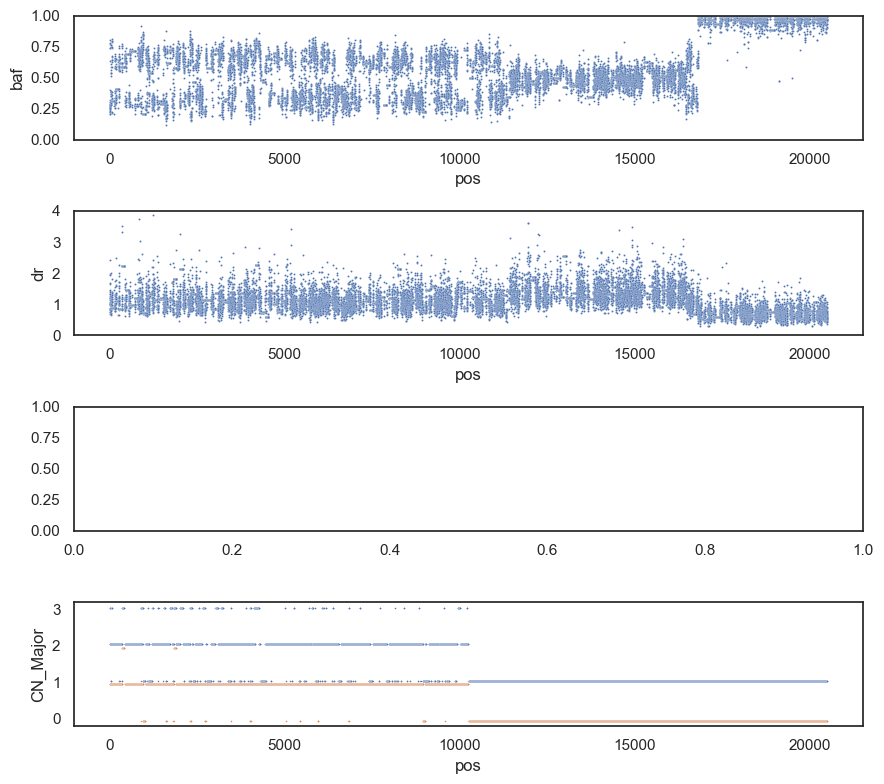

In [21]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=res_tosave, x="pos", y="baf", s=2, ax=axes[0])#, hue="CN")
dr = sns.scatterplot(data=res_tosave, x="pos", y="dr", s=2, ax=axes[1])#, hue="CN", legend=False)
#vaf = sns.scatterplot(data=data, x="pos", y="gt_AF", s=2, ax=axes[2], hue="CN", legend=False)
#dr.vlines(x = bp, ymin = 0, ymax = 4,linestyles = ["dashed"], colors = ["red"])
#baf.vlines(x = bp, ymin = 0, ymax = 1,linestyles = ["dashed"], colors = ["red"])

cn = sns.scatterplot(data=res_tosave, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_tosave, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)
#cn.vlines(x = bp, ymin = 0, ymax = 2,linestyles = ["dashed"], colors = ["red"])

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,4) 
axes[2].set_ylim(0,1) 

# sns.move_legend(
#     baf, 
#     "lower center",
#     bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
#     prop={'size': 12},
#     markerscale=5 
# )

fig.tight_layout()